# Digital modulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Required functions

In [2]:
def CreaConstelacionQAM(N_signals):
    
    Nreales      = int(np.ceil(np.sqrt(N_signals)))
    Nimaginarios = int(np.ceil(np.sqrt(N_signals)))
                 
    parte_real  = np.arange( 0, Nreales )
    parte_imag  = np.arange( 0, Nimaginarios)
    
    v_real= np.tile( np.reshape(parte_real, (Nreales,1)), (1,Nimaginarios) ).flatten()
    v_imag= np.tile( np.reshape(parte_imag, (1,Nimaginarios)), (Nreales,1) ).flatten()
    
    Constelacion= v_real+ 1j*v_imag
    
    # Constelation with zero mean and unit variance
    # Each element in the vector is a complex number that represent a signal
    Constelacion = (Constelacion -Constelacion.mean())/np.sqrt(Constelacion.var())
    return Constelacion


In [3]:
def CreaConstelacionPSK(N_signals):
    
    module=1
    phase = np.arange( 0, 2*np.pi, 2*np.pi/N_signals)
    
    v_real= module*np.cos(phase)
    v_imag= module*np.sin(phase)
    
    Constelacion= v_real+ 1j*v_imag
    
    # Constelación de media cero y varianza unidad
    # Cada elemento del vector es un número complejo que representa una señal
    Constelacion = (Constelacion -Constelacion.mean())/np.sqrt(Constelacion.var())
    return Constelacion

In [4]:
def RepresentaConstelacion(Const):
    
    plt.plot([-1,1],[0,0],'k')
    plt.plot([0,0],[-1,1],'k')
    plt.plot(np.real(Const),np.imag(Const),'o');

In [5]:
def Convert2Signal(Datos, Constelacion):
    
    # We Obtain the bits per symbol of the constellation
    Nbits= int(np.log2(Constelacion.shape[0]))
    
    # Number of signals to transmit
    N_sign_tx = Datos.shape[0]//Nbits
    
    # Bits blocks (each block represent a signal)
    bloques= np.reshape(Datos, (N_sign_tx, Nbits))
    
    # We convert from binary to base 10 (signal identiffier)
    exponentes= np.arange(Nbits-1,-1,-1)    # [ ... 4 3 2 1 0 ]
    Potencias2 = np.tile( np.reshape(np.power(2,exponentes),(1,Nbits)), (N_sign_tx,1))
    Signal_id = np.reshape( np.sum (bloques * Potencias2, axis=1), (N_sign_tx,1))
    # Size (N_sign_tx x 1)
    
    return Signal_id


In [6]:
def ModularEnTiempo(Signal_id, Ts, Constelacion):
    

    N_sign_tx = Signal_id.shape[0]

    # We create the time signal:
    # Ts temporal samples
    
    t = np.arange(0,Ts)             # Size
    t = np.reshape(t, (1,Ts))       #         1 x Ts
    t = np.tile(t, (N_sign_tx,1) )  # N_sign_tx x Ts
    
    Signal_idT = np.tile(Signal_id, (1, Ts) )
    
    Signal_time= np.sqrt(2)*np.abs(Constelacion[Signal_idT])*np.cos(2*np.pi*t/20+np.angle(Constelacion[Signal_idT]))
                                 
    return Signal_time.flatten()
    


In [7]:
def Demodular(Signal_timeRx, Ts): # Ts == Symbol time
    
    
    N_sign_tx = Signal_timeRx.shape[0]//Ts    
    Signals= np.reshape(Signal_timeRx, (N_sign_tx, Ts))
    
    # We Create the basic signals in time:
    # Ts temporal samples
    t = np.arange(0,Ts)             # Size
    t = np.reshape(t, (1,Ts))       #         1 x Ts
    t = np.tile(t, (N_sign_tx,1) )  # N_sign_tx x Ts
    
    # f= 1/20 carrier frequency (if Ts is 100 microseconds, f= 50KHz)
    Base_real= np.sqrt(2)*np.cos(2*np.pi*t/20)
    Base_imag= np.sqrt(2)*np.cos(2*np.pi*t/20+np.pi/2)
    
    a = np.mean(Signals * Base_real, axis=1)
    b = np.mean(Signals * Base_imag, axis=1)
    
    Singal_Rx = a +1j*b
    
    return Singal_Rx
        

In [8]:
def Distancia(Signals, Constellation):
    
    S = np.tile( np.reshape( Signals, (Signals.shape[0], 1)) , (1, Constellation.shape[0]) )
    C = np.tile( np.reshape( Constellation, (1, Constellation.shape[0])) , (Signals.shape[0],1) )
    
    dist = np.abs(np.power(S-C,2))
    
    return dist

In [9]:
def Convert2bits(Signal_id, Constelacion):
    
    # We obtain the constellation bits per symbol
    Nbits= int(np.log2(Constelacion.shape[0]))
        
    bits= np.zeros((Signal_id.shape[0],Nbits), dtype='int')
    
    for k in range(0,Signal_id.shape[0]):
        #bits[k,:]= bitarray(np.binary_repr(Signal_id[k], Nbits));
        bits[k,:]= np.fromstring(np.binary_repr(Signal_id[k], Nbits), dtype=np.uint8)==49
    
    return bits.flatten()


# Creación de una constelación

In [10]:
# PSK/QAM modulation

Nbits = 4 # Nº of bits per symbol
N_signals = 2**Nbits # <= M == Nº of different signals
print('Nunmber of signals:', N_signals)

Const = CreaConstelacionPSK(N_signals)
#Const = CreaConstelacionQAM(N_signals)


Nunmber of signals: 16


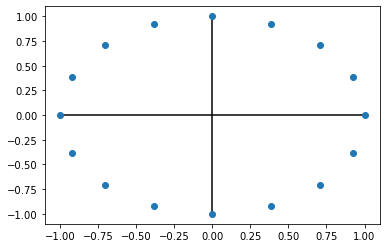

In [11]:
RepresentaConstelacion(Const)

# Mean constellation power

In [12]:
print('Varianza de la constelación:', Const.var())

Varianza de la constelación: 1.0


# Creation of the signals in time

In [13]:
# We create binary data to convert it into signals in time
# We use a multiple length of Nbits to be able to convert the data into signals (one signal every Nbits)
# For example, 5 * Nbits => we will transmit 5 signals
Datos_binarios=(np.random.rand(1000*Nbits)<0.5)*1;

if(Datos_binarios.shape[0]<50):
    fig=plt.figure(figsize=(8, 4))
    plt.stem(Datos_binarios);
    plt.title('Random binary signal');

Ts=100 # Symbol time = 100 (for example 100 microseconds)
Signal_id= Convert2Signal(Datos_binarios, Const)
Signal_time= ModularEnTiempo(Signal_id, Ts, Const)
print(Signal_id)

[[ 9]
 [15]
 [14]
 [14]
 [13]
 [ 6]
 [11]
 [12]
 [ 9]
 [11]
 [ 8]
 [ 9]
 [ 9]
 [ 5]
 [12]
 [13]
 [ 3]
 [ 8]
 [14]
 [13]
 [ 3]
 [ 3]
 [ 9]
 [12]
 [ 0]
 [ 3]
 [13]
 [ 6]
 [ 4]
 [ 9]
 [ 9]
 [13]
 [15]
 [ 2]
 [13]
 [ 1]
 [ 1]
 [ 2]
 [ 6]
 [ 3]
 [15]
 [10]
 [ 3]
 [ 2]
 [11]
 [14]
 [ 1]
 [10]
 [12]
 [11]
 [ 4]
 [ 0]
 [14]
 [ 9]
 [ 2]
 [15]
 [ 3]
 [14]
 [ 0]
 [ 0]
 [11]
 [ 8]
 [14]
 [13]
 [ 5]
 [13]
 [ 5]
 [11]
 [ 2]
 [ 2]
 [ 3]
 [ 3]
 [12]
 [ 9]
 [12]
 [ 5]
 [11]
 [ 5]
 [ 3]
 [ 6]
 [ 6]
 [ 3]
 [10]
 [11]
 [ 9]
 [15]
 [ 7]
 [ 2]
 [ 5]
 [13]
 [ 2]
 [ 2]
 [ 8]
 [14]
 [12]
 [12]
 [13]
 [12]
 [ 7]
 [12]
 [ 4]
 [ 9]
 [15]
 [ 6]
 [ 5]
 [ 3]
 [ 2]
 [15]
 [ 6]
 [15]
 [ 1]
 [ 0]
 [ 2]
 [14]
 [ 4]
 [14]
 [ 1]
 [ 5]
 [ 9]
 [ 1]
 [ 4]
 [ 3]
 [ 7]
 [14]
 [ 0]
 [12]
 [ 2]
 [15]
 [ 7]
 [14]
 [ 1]
 [ 7]
 [12]
 [10]
 [ 2]
 [ 8]
 [12]
 [12]
 [15]
 [ 6]
 [10]
 [12]
 [ 6]
 [12]
 [ 7]
 [ 6]
 [ 8]
 [ 8]
 [ 3]
 [ 0]
 [15]
 [13]
 [15]
 [ 6]
 [ 4]
 [10]
 [ 8]
 [11]
 [ 1]
 [10]
 [ 6]
 [ 0]
 [ 6]
 [ 4]
 [ 5]
 [14]
 [12

In [14]:
# Mean power of the signal
Signal_time.var()
# Why does the average power change with the signal? Shouldn't it be equal to 1?

1.0

In [15]:
if(Datos_binarios.shape[0]<1000): # To ensure we see the signal clearly, it is only represented 
                                  # if it is not very long
    fig=plt.figure(figsize=(8, 4))
    plt.plot(Signal_time)

# Adding noise

In [16]:
# Noise power in time
N = 2
Ruido= np.sqrt(N)*np.random.randn(Signal_time.shape[0])
print('Noise power in time:', Ruido.var())


Noise power in time: 1.9967108064215036


In [17]:
Signal_timeRx= Signal_time + Ruido

if(Datos_binarios.shape[0]<1000):
    fig=plt.figure(figsize=(8, 4))
    plt.plot(Signal_timeRx)

In [18]:
if(Datos_binarios.shape[0]<1000):
    fig=plt.figure(figsize=(16, 8))

    EspectroNoise=np.fft.fft(Ruido)
    plt.plot(np.abs(EspectroNoise))

    EspectroTx=np.fft.fft(Signal_time)
    plt.plot(np.abs(EspectroTx))

    plt.legend([ 'EspectroNoise', 'EsprectroTx'])

In [19]:

Band_base_noise=Demodular(Ruido, Ts)
print('Recovered power noise:',Band_base_noise.var())

Recovered power noise: 0.03914616969436679


# We read the receiver signal

In [20]:
Signal_Rx= Demodular(Signal_timeRx, Ts)

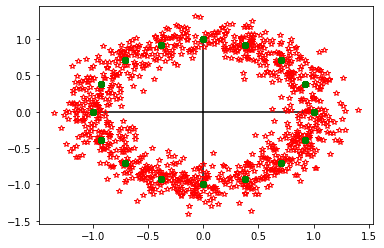

In [21]:
RepresentaConstelacion(Const)
plt.plot(np.real(Signal_Rx), np.imag(Signal_Rx),'r*', mfc='none');
plt.plot(np.real(Const[Signal_id]), np.imag(Const[Signal_id]),'go');
# The green dots are the signals sent, the red dots the values received

# We obtain the identifier for each signal (closest signal)

In [22]:
dist= Distancia( Signal_Rx, Const)
Signal_id_Rx = np.argmin(dist, axis=1)
if(Datos_binarios.shape[0]<1000):
    print( 'Obtained signals: ', Signal_id_Rx)
    print('Sended signals:', Signal_id[:,0])

In [23]:
# Receiver noise as the difference between sended and received:
Baseband_noise = Signal_Rx-Const[Signal_id[:,0]]
print('Noise power in baseband:', Baseband_noise.var())

Noise power in baseband: 0.03914616969436679


In [24]:
SNR= Const[Signal_id[:,0]].var()/Baseband_noise.var()
print('SNR=',SNR)

SNR= 25.500845246860813


# BER calculation

In [25]:
# First we convert the signals to bits
bits= Convert2bits(Signal_id_Rx, Const)

<ipython-input-9-99ac83afb3c0>:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  bits[k,:]= np.fromstring(np.binary_repr(Signal_id[k], Nbits), dtype=np.uint8)==49


In [26]:
bits

array([1, 0, 0, ..., 1, 0, 0])

In [27]:
Datos_binarios

array([1, 0, 0, ..., 1, 0, 0])

In [28]:
if(Datos_binarios.shape[0]<50):
    plt.stem(Datos_binarios);
    plt.title('Original');
    plt.figure();
    plt.stem(bits); 
    plt.title('Received');

In [29]:
BER= np.mean(Datos_binarios!=bits)
print('BER=', BER)

BER= 0.08275
